<img src="portfolio_gothic.png" />

If someone says “gothic” to you, do you think of lush rolling countryside or a sunny day?

Chances are you don’t.  Most people - myself included - associate that word with things that are dark, mysterious and even frightening.  Maybe you picture ornate stone architecture of a castle or a cathedra with gargoyles. Or perhaps foreboding skies rolling over said castle.  Or very morose, pale people wearing black capes and veils.  Or vampires with all of the above.

About a year ago, [Caroline Winter](https://carolinewinter.com/), a PhD student at the University of Victoria, emailed me with a question.  She had assembled a [corpus of 134 works of European Gothic literature](https://github.com/eleanorstrib/gothic/tree/master/corpora) that had been written or translated into English, ranging from the 18th century to the early 20th.  Could I write her a short script to count and analyze color words for a broad corpus she’d assembled as a survey of Gothic literature she was studying?  Because her hunch was that gothic literature was greener and less bleak and grim than most people thought.

This post tells the story of how a quick Python project for a Sunday afternoon morphed into a talk at PyCon.  Through some pretty straightforward counting and matching techniques, we were able to find some interesting patterns that challenged my gloomy picture of “gothic”.  

This Jupyter Notebook is a companion to the post on the [Kite.com blog](https://kite.com/blog) published in September 2018.


In [79]:
# first let's import the libraries and functions we need
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import string
from collections import Counter, defaultdict, OrderedDict
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/estribling/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/estribling/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# for this example, I've selected one text from the "corpora" folder; the path will be added when we run the function
title_file = 'Leroux_ThePhantomOfTheOpera_Gutenberg.txt'
title = "The Phantom of the Opera"

### Beyond black, white and red

The first step in the project was to define what color words we were looking for.  The challenge here was that both the vocabulary used to describe color and the actual coloring of objects themselves were different in the gothic era than we think of them in the late 2010s.

Rather than guess about historical color words, we turned to the Oxford English Dictionary’s Historical Thesaurus (OEDHT).  It lists English, predominantly European color words, the year of each one’s first recorded use, and its color family.  

After adding some html color names based on color grouping to our csv file of the original data set (also in this repo), I read a csv file with the OEDHT data into a short function and eliminated everything that came into usage after 1914, since it’s not clear from the data when words fell out of usage.  

In [3]:
def id_color_words():
    """
    Gets color words from the csv file and puts them into a dict where key = word
    and value = (hex value, color family); removes pre-1914 color words.
    """
    color_word_dict = {}
    modern_color_words = []
    color_data = csv.DictReader(open('./color_names.csv'), delimiter=",", quotechar='"')

    for row in color_data:
        name = row['Colour Name'].lower()
        year = int(row['First Usage'])
        if ' ' not in name:
            if year < 1914:
                family = row['Colour Family'].lower()
                hex_value = row['hex'].lower()
                color_word_dict[name] = (hex_value, family)
            else:
                modern_color_words.append((year, name))
                   
    return color_word_dict, modern_color_words

This gave us a dictionary of 980 pre-WWI color words ranging from the familiar, like blue (first usage 1300), crimson (1416), or jet (1607), to the uncommon, like corbeau (1810, dark green), damask (1598, pink) or ochroid (1897, pale yellow).  There were also some instances where the way words were categorized reflected an historical state of familiar things for example, ‘glass’ is categorized as a greyish green, not pale blue or clear as we may think of it today.

Now we knew what we were looking for, but getting this right was about more than counting these color words.

In [4]:
color_dict, modern_color_words = id_color_words()

print("There are %d color words in our dictionary that were in use before 1914, per the OED." % len(color_dict))
print()
sample_colors = list(color_dict.keys())[230:240]
print("Here is a sample - first value in the tuple is the HTML color, the second is the color family.")
for s in sample_colors:
    print(s, ":", color_dict[s])

There are 980 color words in our dictionary that were in use before 1914, per the OED.

Here is a sample - first value in the tuple is the HTML color, the second is the color family.
miniate : ('red', 'bright red or scarlet')
nasturtium-red : ('red', 'bright red or scarlet')
blood-red : ('crimson', 'deep red or crimson')
bloody : ('crimson', 'deep red or crimson')
purpurine : ('purple', 'purple ')
sanguine : ('crimson', 'deep red or crimson')
tuly : ('crimson', 'deep red or crimson')
murrey : ('crimson', 'deep red or crimson')
purpure : ('purple', 'purple ')
crimson : ('crimson', 'deep red or crimson')


In [5]:
# what we're discarding from the data set is also interesting
print("Here are the post-1914 words and the year of first usage according to the Oxford English Dictionary.")
print("The 20th century ushered in food-related color words including avocado, citron, cocoa, mustard, pimento & toffee.")
print()
print(json.dumps(dict(sorted(modern_color_words, key=lambda x: x[0])), indent=1))

Here are the post-1914 words and the year of first usage according to the Oxford English Dictionary.
The 20th century ushered in food-related color words including avocado, citron, cocoa, mustard, pimento & toffee.

{
 "1918": "shadow-grey",
 "1919": "mustard",
 "1921": "pimento",
 "1922": "straw-pale",
 "1923": "sahara",
 "1924": "hennaed",
 "1927": "greige",
 "1928": "mimosa",
 "1931": "magnolia-pink",
 "1934": "safari",
 "1935": "salmony",
 "1937": "seaweed-green",
 "1938": "guinea-gold",
 "1941": "prune-dark",
 "1942": "cocoa",
 "1946": "whale-blue",
 "1947": "avocado",
 "1949": "saffronic",
 "1950": "wine",
 "1951": "bone-coloured",
 "1953": "pinko-grey",
 "1961": "toffee-brown",
 "1962": "peppery",
 "1963": "magnolia",
 "1965": "nutmeg",
 "1970": "flame",
 "1971": "sunshine-yellow",
 "1975": "sludgy",
 "1977": "tangerine-coloured",
 "1978": "spun-golden",
 "1981": "pepperminty",
 "1991": "mango"
}


### ‘rose’ != ‘rose’ != ‘rose’
<div align="center" style="margin: 0 auto;">
    <div style="width: 50%;float: left;"><img src="roseisarose.png"></div>
    <div><p>
    English is a tricky language, with many words that sound the same mean different things and many words that look the same mean different things in context. ‘Rose’ is a great example: it can be a noun, adjective or a verb, as demonstrated in the gif below.

<p>So which words should we count?  Should every word on the list be included?

<p>To make this decision, we needed to write more code to parse our corpus and look at the results. 

<p>The function below, `process_text` reads in the text file for a single work, removes the “gristle” - stop words, punctuation, and puts remaining words all in lowercase - then tags them for part of speech (noun, verb, adjective, etc.) using the Natural Language Toolkit (NLTK) ‘pos_tag’ function.</p>
    </div>
</div>

In [87]:
def process_text(filename):
    """
    This function generates a list of tokens with punctuation stopwords, and spaces removed for the whole text.
    It also applies NLTK's part of speech tagging function to determine if words are nouns, adjectives, verbs, etc.
    """
    text_tokens = []
    
    # create a list of the words and punctuation we want to remove before analyzing
    stop_punc = set(stopwords.words('english') + [*string.punctuation] + ["''", '``'])
    
    with open(filename) as text:
        for row in text:
            # puts everything in lowercase, postion tags
            for token in pos_tag(word_tokenize(row.lower())):
                #removes tokens if contains punctuation or stopwords
                if token and token[0] not in stop_punc:
                    text_tokens.append(token)

    return text_tokens

In [7]:
# let's run the function and look at a sample of the data we've generated
processed = process_text(title_file)
print(processed[300:320])

[('memoirs', 'NNS'), ('manager', 'NN'), ('light', 'NN'), ('frivolous', 'JJ'), ('work', 'NN'), ('too-skeptical', 'JJ'), ('moncharmin', 'NN'), ('term', 'NN'), ('opera', 'NN'), ('understood', 'JJ'), ('nothing', 'NN'), ('mysterious', 'JJ'), ('behavior', 'NN'), ('ghost', 'NN'), ('making', 'VBG'), ('fun', 'NN'), ('could', 'MD'), ('moment', 'NN'), ('became', 'VBD'), ('first', 'JJ')]


In [80]:
def find_color_words(t, color_dict):
    """
    This function identifies adjectives and nouns in the text that match contemporary color words in the color_dict,
    then checks to see if the word before or after it is also a color word to help the analyst determine if they want
    to count instances where two color words are found together - e.g. "red rose", or "white marble"
    """
    color_words = []
    concurrent_color_words = []
    tags = {'JJ', 'NN'} # JJ = adjectives, NN = nouns
    
    current_idx = 0
    
    while current_idx < len(t):
        # check if the word is in the color_dict and has the correct tags
        if t[current_idx][1] in tags and t[current_idx][0] in color_dict:
            color_words.append(t[current_idx])

            # check the next word to see if it's in the color_dict
            next_idx = current_idx + 1
            if t[next_idx][1] in tags and t[next_idx][0] in color_dict:
                color_words.append(t[next_idx])
                concurrent_color_words.append((t[current_idx], t[next_idx]))
                # increment current_idx by an extra step
                current_idx = next_idx
        # increment current_idx by 1
        current_idx += 1
        
    return color_words, concurrent_color_words

In [81]:
color_in_text, concurrent_color_words = find_color_words(processed, color_dict)

print("Here's a sample of what our list of color words looks like:")
print(color_in_text[:20])
print()
if len(concurrent_color_words) > 1:
    print("Here is a sample of the concurrent color words, instances where we had a color noun with a color adjective:")
    print(concurrent_color_words[:10])
else:
    print("No concurrent color words (e.g. 'red rose' or 'yellow orange') were found!")

Here's a sample of what our list of color words looks like:
[('yellow', 'JJ'), ('black', 'JJ'), ('mourning', 'NN'), ('rose-red', 'JJ'), ('lily-white', 'JJ'), ('black', 'JJ'), ('black', 'JJ'), ('black', 'JJ'), ('white', 'JJ'), ('yellow', 'NN'), ('plum', 'NN'), ('glass', 'NN'), ('red', 'JJ'), ('coral', 'JJ'), ('pink', 'NN'), ('iron', 'NN'), ('glass', 'NN'), ('pink', 'JJ'), ('candid', 'JJ'), ('blue', 'JJ')]

Here is a sample of the concurrent color words, instances where we had a color noun with a color adjective:
[(('glass', 'NN'), ('champagne', 'NN')), (('red', 'JJ'), ('white', 'JJ')), (('pink', 'NN'), ('blush', 'NN')), (('glass', 'NN'), ('champagne', 'NN')), (('pink', 'NN'), ('white', 'JJ')), (('gold', 'NN'), ('purple', 'NN')), (('water', 'NN'), ('bluey', 'NN')), (('glass', 'NN'), ('glass', 'NN')), (('red', 'JJ'), ('red', 'JJ')), (('water', 'NN'), ('water', 'NN'))]


This function outputs the whole text that looks like this - as you can see `pos_tag` doesn’t look like it gets the part of speech correct every time, but it’s pretty close.

In [82]:
print("Here's a sample of what our list of color words looks like:")
print(color_in_text[:20])

Here's a sample of what our list of color words looks like:
[('yellow', 'JJ'), ('black', 'JJ'), ('mourning', 'NN'), ('rose-red', 'JJ'), ('lily-white', 'JJ'), ('black', 'JJ'), ('black', 'JJ'), ('black', 'JJ'), ('white', 'JJ'), ('yellow', 'NN'), ('plum', 'NN'), ('glass', 'NN'), ('red', 'JJ'), ('coral', 'JJ'), ('pink', 'NN'), ('iron', 'NN'), ('glass', 'NN'), ('pink', 'JJ'), ('candid', 'JJ'), ('blue', 'JJ')]


Here’s what we get from this function.

First, a list of all of the identified color words in the text and their tag, like this:

`[('yellow', 'JJ'), ('black', 'JJ'), ('mourning', 'NN'), ('rose-red', 'JJ'), ('lily-white', 'JJ'), ('black', 'JJ'), ('black', 'JJ'), ('black', 'JJ'), ('white', 'JJ'), ('yellow', 'NN'), ('plum', 'NN'), ('glass', 'NN'), ('red', 'JJ'), ('coral', 'JJ'), ('pink', 'NN'), ('iron', 'NN'), ('glass', 'NN'), ('pink', 'JJ'), ('candid', 'JJ'), ('blue', 'JJ')]`

Second, we get a list of tuples containing the color words that were adjectives or nouns followed by another adjective or noun closely in the original text.  From The Phantom of the Opera, we get examples like:
`(('glass', 'NN'), ('champagne', 'NN'))
(('pink', 'NN'), ('white', 'JJ'))
(('gold', 'NN'), ('purple', 'NN'))
(('water', 'NN'), ('bluey', 'NN'))`
In most cases we didn’t think one of these took anything away from or obscured the other; in fact their close association painted a clearer picture of color and in some cases texture.  So we left both words in.

From this you can get some summary stats, like what percentage of the uncommon words in the text were color words (Phantom is 0.9%), and what proportion are nouns versus adjectives (Phantom is 52-47).


In [83]:
#some descriptive statistics!
nouns = Counter([n[0] for n in color_in_text if n[1] == 'NN'])
total_nouns = sum(nouns.values())
adjectives = Counter([a[0] for a in color_in_text if a[1] == 'JJ'])
total_adjectives = sum(adjectives.values())
total_color_words = len(color_in_text)
pct_color_words = round((total_color_words/len(processed))*100, 2)

print("There are %d nouns in our color word list:" % total_nouns)
print(nouns)
print()
print("And %d adjectives in our color word list:" % total_adjectives)
print(adjectives)
print()
print("%s is %s percent color words."% (title, pct_color_words))
print("~%d percent of the color words are nouns." % round((total_nouns/total_color_words)*100, 1))
print("~%d percent of the color words are adjectives." % round((total_adjectives/total_color_words)*100, 1))

There are 182 nouns in our color word list:
Counter({'water': 56, 'glass': 24, 'iron': 20, 'stone': 19, 'gold': 10, 'bronze': 5, 'pink': 4, 'snow': 4, 'marble': 4, 'rush': 3, 'crimson': 3, 'champagne': 2, 'wan': 2, 'blush': 2, 'scarlet': 2, 'bluey': 2, 'mahogany': 2, 'mourning': 1, 'yellow': 1, 'plum': 1, 'navy': 1, 'peacock': 1, 'straw': 1, 'ivory': 1, 'copper': 1, 'chocolate': 1, 'blue': 1, 'candid': 1, 'purple': 1, 'incarnate': 1, 'mole': 1, 'inky': 1, 'stony': 1, 'gunpowder': 1, 'violet': 1})

And 169 adjectives in our color word list:
Counter({'red': 45, 'black': 40, 'white': 30, 'rosy': 9, 'yellow': 8, 'blue': 8, 'marble': 7, 'golden': 5, 'leaden': 3, 'candid': 2, 'green': 2, 'rose-red': 1, 'lily-white': 1, 'coral': 1, 'pink': 1, 'purple': 1, 'smoky': 1, 'glaucous': 1, 'rusty': 1, 'metallic': 1, 'pitchy': 1})

The Phantom of the Opera is 0.84 percent color words.
~51 percent of the color words are nouns.
~48 percent of the color words are adjectives.


Next, we needed to isolate the color words from the text and do some analysis of the context to make sure there weren’t any glaring issues in the data we were generating.  Here Caroline’s literature background was extremely helpful in identifying what looked off, and I went off to pull out the context of the suspicious words so she could make a final call.

Some examples of words we eliminated based on context were:
Isabella, a yellowish color that was also the name of a couple of characters in our corpus;
Imperial, a purple color that, in the texts actually meant the political structure, not the color; and
Angry, sometimes used to describe a red-pink flushed color, but was used more an an emotion word than a color word.

At this stage, I also experimented with stemming and lemmatization of the color words in our master list and in the texts themselves to see if that changed how many color words we were finding, rather than looking for exact matches.  What this means, for example, is transforming the word “whitish” from the OEDHT to its root, or stem (“white”) and doing the same to the words in the text we were analyzing. However, because the OEDHT is so comprehensive and already included many forms of each word, the results didn’t change much so we left out that step.

Looking at the preliminary data, we also found that we got some combinations of color words, like “rose” followed by “red” or “milky” followed by “white”.  While OEDHT covers common combinations of these when they’re joined with a “-” (e.g. “rose-red”) we decided to isolate those examples in the output of the `find_color_words` to help us determine if we wanted to exclude those samples from the final analysis.


### Analysis & Visualization - the (really) fun part
With adjustments made to the color word list, we were ready to run the texts through our `find_color_words` function again to see the results. 

In [84]:
def group_to_plot(color_dict, c_i_t):
    color_summary = defaultdict(int)
    for c in c_i_t:
        color_summary[color_dict[c[0]][0]] += 1
    color_sum_a = dict(OrderedDict(sorted(color_summary.items(), key=lambda t: t[1])))
    color_sum_d = dict(OrderedDict(sorted(color_summary.items(), key=lambda t: t[1], reverse=True)))
    return color_sum_a, color_sum_d

In [85]:
html_color_counts_asc, html_color_counts_dsc  = group_to_plot(color_dict, color_in_text)
print (json.dumps(html_color_counts_dsc, indent=1))

{
 "cadetblue": 57,
 "red": 48,
 "black": 42,
 "silver": 30,
 "lightseagreen": 25,
 "dimgrey": 21,
 "lightslategrey": 20,
 "pink": 18,
 "gold": 15,
 "white": 14,
 "blue": 12,
 "yellow": 9,
 "slategrey": 5,
 "darkgoldenrod": 5,
 "snow": 4,
 "darkred": 4,
 "purple": 3,
 "firebrick": 3,
 "crimson": 3,
 "papayawhip": 2,
 "green": 2,
 "floralwhite": 1,
 "darkblue": 1,
 "turquoise": 1,
 "lightyellow": 1,
 "whitesmoke": 1,
 "ivory": 1,
 "sienna": 1,
 "steelblue": 1,
 "blueviolet": 1
}


Let's use matplotlib to add a bar chart of the top 10 colors in the book.

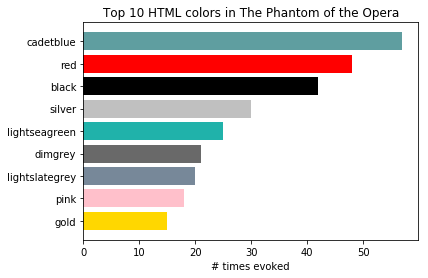

In [86]:
colors = list(html_color_counts_asc.keys())[-9:]
counts = list(html_color_counts_asc.values())[-9:]
y_pos = np.arange(len(counts))

plt.barh(y_pos, counts, align='center', color=colors)
plt.yticks(y_pos, colors)
plt.xlabel('# times evoked')
plt.title('Top 10 HTML colors in ' + title)

plt.show()

There are many of interesting options for visualizing this data. The original talk included a [website](https://afternoon-taiga-69837.herokuapp.com/), built with the Django framework and ChartJS and lots of CSS where - using a slightly different methodology - we visualized each book as a series of color blocks in their order of appearance, and each author's works as a radial chart.

<img src='phantom.png'>

### Beyond this post
If you take a few minutes to explore the website, even with the limitations of HTML color applied to a broad palette, you’ll see that a lot of the books are not as dark and gloomy as their “gothic” label might lead you to believe.  This makes sense: the supernatural is a strong theme in Gothic, but so is contrasting it with the beauty of natural world that was considered both a haven and a dwindling reality as the industrial revolution began.

There is so many ways that computing could be used for humanities scholarship to complement the strong traditions already there.  If you’d like to learn more about this project after reviewing , please [watch the original talk](https://www.youtube.com/watch?v=3dDtACSYVx0) and [visit the website](https://afternoon-taiga-69837.herokuapp.com/), check out the [repo and the corpus](https://github.com/eleanorstrib/gothic).  If you prefer to work with more recent literature, check out my 2018 project where I [explain and quantify gender bias in the Harry Potter series using Python](https://medium.com/agatha-codes/a-bossy-sort-of-voice-3c3a18de3093). 
